# Calibrating the concept learning layer of concept bottleneck models

This is based heavily on [Koh et al 2020](https://arxiv.org/pdf/2007.04612) and I'm only implementing independent and sequential models because it's 6am and I wanna sleep.

Actually, sequential only, because independent doesn't benefit from calibration expect through accuracy (it takes binary concept membership inputs because that's what it's trained on).

In [1]:
import pandas as pd
import numpy as np
import torch
import os
from IPython.display import display
from scipy.special import logit, expit
import torch.nn as nn
import pickle

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.frozen import FrozenEstimator

from models import get_global_threshold, get_individual_thresholds
from models import get_global_similarity_log_reg, get_similarity_log_reg
from models import get_embeddings_log_reg
from models import get_global_sim_X_y, get_concept_sim_X_y

from calibration_framework import apply_platt_scaling, apply_isotonic_regression, apply_temperature_scaling
from calibration_framework import apply_histogram_binning, apply_beta_calibration

from utils import compare_all_models_calibration_metric, compare_all_models_calibration_avg, compare_all_models_calibration_concept

from matplotlib import pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
dataset_name = 'CUB'

## 1. Get pre-processed data

I don't need concept activation vectors or cosine similarities for actually doing the thing, but it can be interesting to compare.

In [3]:
metadata_df = pd.read_csv(f'../Data/{dataset_name}/metadata.csv')
embeddings = torch.load(f'Embeddings/{dataset_name}/embeddings.pt')
cosine_similarity_df = pd.read_csv(f'Cosine_Similarities/{dataset_name}/cosine_similarities.csv')

/tmp/ipykernel_725992/2056268533.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings = torch.load(f'Embeddings/{dataset_name}/embeddings.pt')


In [4]:
if dataset_name == 'CLEVR':
    metadata_df = metadata_df.drop(['size::large','material::rubber'], axis=1)
    cosine_similarity_df = cosine_similarity_df.drop(['size::large','material::rubber'], axis=1)

In [100]:
concepts = list(cosine_similarity_df.columns)
classes = metadata_df['class'].unique()
classes.sort()

train_mask = metadata_df['split'] == 'train'
train_embeddings = embeddings[train_mask]
train_metadata_df = metadata_df[train_mask].reset_index(drop=True)
train_cosine_similarity_df = cosine_similarity_df[train_mask].reset_index(drop=True)
train_concepts = torch.from_numpy(train_metadata_df[concepts].to_numpy()) # each row is a k-dimensional y-value
train_labels = train_metadata_df["class"]

cal_mask = metadata_df['split'] == 'calibration'
cal_embeddings = embeddings[cal_mask]
cal_metadata_df = metadata_df[cal_mask].reset_index(drop=True)
cal_cosine_similarity_df = cosine_similarity_df[cal_mask].reset_index(drop=True)
cal_concepts = torch.from_numpy(cal_metadata_df[concepts].to_numpy())
cal_labels = cal_metadata_df["class"]

test_mask = metadata_df['split'] == 'test'
test_embeddings = embeddings[test_mask]
test_metadata_df = metadata_df[test_mask].reset_index(drop=True)
test_cosine_similarity_df = cosine_similarity_df[test_mask].reset_index(drop=True)
test_concepts = torch.from_numpy(test_metadata_df[concepts].to_numpy())
test_labels = test_metadata_df["class"]

In [113]:
train_labels_onehot = pd.get_dummies(train_labels)
cal_labels_onehot = pd.get_dummies(cal_labels)
test_labels_onehot = pd.get_dummies(test_labels)

assert((train_labels_onehot.columns == classes).all())
assert((cal_labels_onehot.columns == classes).all())
assert((test_labels_onehot.columns == classes).all())

train_labels_onehot = train_labels_onehot.to_numpy(dtype=int)
cal_labels_onehot = cal_labels_onehot.to_numpy(dtype=int)
test_labels_onehot = test_labels_onehot.to_numpy(dtype=int)

## 2. Concept Model Utils
### a) Base Models

In [217]:
def concept_accuracies(all_y_pred, all_y_true, verbose = True, ste_coef=1, individual = True):
    ret = {}
    
    # individual concept accuracies
    if individual:
        for i, concept in enumerate(concepts):
            y_true = all_y_true[:, i]
            y_pred = all_y_pred[:, i]
            
            accuracy = accuracy_score(y_true, y_pred)
            ste = ste_coef * (accuracy * (1 - accuracy) / len(y_true))**0.5
            ret[concept] = (accuracy, ste)
            
            if verbose:
                print(f"{i}. {concept} Test Accuracy: {accuracy * 100:.2f} \u00B1 {ste * 100:.2f}%")

    # overall accuracy
    accuracy = accuracy_score(all_y_true.flatten(), all_y_pred.flatten())
    ste = ste_coef * (accuracy * (1 - accuracy) / len(all_y_true.flatten()))**0.5

    if verbose:
        print(f"Test Accuracy: {accuracy * 100:.2f} \u00B1 {ste * 100:.2f}%")

    if individual:
        return accuracy, ste, ret
    return accuracy, ste

In [73]:
def target_accuracy(y_pred, y_true, verbose = True, ste_coef=1):
    accuracy = accuracy_score(y_true, y_pred)
    ste = ste_coef * (accuracy * (1 - accuracy) / len(y_true))**0.5

    if verbose:
        print(f"Test Accuracy: {accuracy * 100:.2f} \u00B1 {ste * 100:.2f}%")
    
    return accuracy, ste

In [8]:
# parent class
class ConceptModel(nn.Module):
    """
    Construct a ConceptModel instance (the X-to-concept layer of a concept bottleneck model)
    === Parameters ===
    concepts : array-like of string-type elements
        List of concept names
    model_constructor : str -> nn.Module, optional, default: MLP constructor
        Function mapping a concept name to a model instance, to be used to predict the presence of that concept on data samples
    seed : int, optional, default: None (random seeds for each concept model)
        Random seed to be used in model construction. If None, no seed is provided and the classifier uses a random seed
    info : Dict
        General metadata/info. Good to include name, description, etc.
    """
    def __init__(self, concepts, seed = None, info = None):
        super(ConceptModel, self).__init__()
        self.concepts = concepts
        self.seed = seed
        self.info = info
        self._is_fitted = False
    
    """
    Fit all concept models to training dataset
    === Parameters ===
    X : ndarray-like (n, d) where n is the number of samples and d is the dimension of elements in the input space)
        Array of input features of whatever type is acceptable to the individual concept models (probably float arrays)
    y : ndarray-like (n, k) where n is the number of samples and k is the number of concepts in the concept space)
        Array of 1-0 concept labels for X
    verbose : bool, optional, default: False
        Whether to print progress during training
    """
    def fit(self, X, y, verbose = False):
        raise NotImplementedError()
    
    """
    Predict concept probabilities on a dataset
    === Parameters ===
    X : ndarray-like (n, d) where n is the number of samples and d is the dimension of elements in the input space)
        Array of input features of whatever type is acceptable to the individual concept models (probably float arrays)
    === Output ===
    y : ndarray-like (n, k) where n is the number of samples and k is the number of concepts in the concept space)
        Array of concept probabilities in [0, 1] for X
    """
    def predict_proba(self, X):
        raise NotImplementedError()

    """
    Compute non-probabilistic concept scores on a dataset
    === Parameters ===
    X : ndarray-like (n, d) where n is the number of samples and d is the dimension of elements in the input space)
        Array of input features of whatever type is acceptable to the individual concept models (probably float arrays)
    === Output ===
    z : ndarray-like (n, k) where n is the number of samples and k is the number of concepts in the concept space)
        Array of non-probabilistic concept scores on the real line for X
    """
    def decision_function(self, X, eps = 0.000001):
        return logit(np.clip(self.predict_proba(X), eps, 1 - eps))

    """
    Predict concept labels on a dataset, given similarity scores
    === Parameters ===
    X : ndarray-like (n, d) where n is the number of samples and d is the dimension of elements in the input space)
        Array of input features of whatever type is acceptable to the individual concept models (probably float arrays)
    === Output ===
    y : ndarray-like (n, k) where n is the number of samples and k is the number of concepts in the concept space)
        Matrix of 0-1 concept indicators for X
    """
    def predict(self, X):
        return self.predict_proba(X) > 0.5

    def __sklearn_is_fitted__(self):
        return self._is_fitted

In [17]:
# because I don't have direct acccess to the concept activation vectors in this script, this API is a little wonky -- don't assume anything.
# used for M1
class CosineSimilarityModel(ConceptModel):
    def __init__(self, concepts, seed = None, info = None):
        # super(CosineSimilarityModel, self).__init__()
        # self.concepts = concepts
        # self.info = info
        super(CosineSimilarityModel, self).__init__(concepts, seed, info)
        
        self.concept_models = {}
        for concept in self.concepts:
            self.concept_models[concept] = LogisticRegression(random_state=seed, max_iter=1000)

    """
    Fit all concept models to training dataset (given X = train_cosine_similarity_df and y = train_concepts)
    === Parameters ===
    X : dataframe of shape (n, k) where n is the number of samples and k is the number of concepts in the concept space
        Matrix of similarity scores
    y : ndarray-like (n, k) where n is the number of samples and k is the number of concepts in the concept space)
        Matrix of 1-0 concept labels for X
    verbose : bool, optional, default: False
        Whether to print progress during training
    """
    def fit(self, X, y, verbose = False):
        # preprocess
        if type(X) is pd.core.frame.DataFrame:
            X = X.to_numpy()
        # do the thing
        for i, concept in enumerate(self.concepts):
            X_concept = X[:, i].reshape(-1, 1) # X[concept].to_numpy().reshape(-1, 1)
            y_concept = y[:, i]
            if verbose:
                print("{:03d}. Training {} detector with {} positive examples (of {})".format(i, concept, y_concept.sum(), len(y_concept)))
            self.concept_models[concept].fit(X_concept, y_concept)
        self._is_fitted = True

    """
    Predict concept probabilities on a dataset, given similarity scores
    === Parameters ===
    X : dataframe of shape (n, k) where n is the number of samples and k is the number of concepts in the concept space
        Matrix of similarity scores
    === Output ===
    y : ndarray-like (n, k) where n is the number of samples and k is the number of concepts in the concept space)
        Matrix of concept probabilities in [0, 1] for X
    """
    def predict_proba(self, X):
        # preprocess
        if type(X) is pd.core.frame.DataFrame:
            X = X.to_numpy()
        # do the thing
        y = np.empty(shape=(len(X), len(self.concepts)))
        for i, concept in enumerate(self.concepts):
            y[:, i] = self.concept_models[concept].predict_proba(X[:, i].reshape(-1, 1))[:, 1] # only need positive label probabilities
        return y

In [18]:
"""
used for M2 (slow)
"""
class MLPConceptModel(ConceptModel):
    def __init__(self, concepts, seed = None, info = None):
        super(MLPConceptModel, self).__init__(concepts, seed, info)
        
        self.model_constructor = lambda concept : MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=200) if self.seed is None else MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=200, random_state = self.seed)
        
        self.concept_models = {}
        for concept in self.concepts:
            self.concept_models[concept] = self.model_constructor(concept)
    
    def fit(self, X, y, verbose = False):
        for i, concept in enumerate(self.concepts):
            y_concept = y[:, i]
            if verbose:
                print("{:03d}. Training {} detector with {} positive examples (of {})".format(i, concept, y_concept.sum(), len(y_concept)))
            self.concept_models[concept].fit(X, y_concept)
        self._is_fitted = True

    def predict_proba(self, X):
        y = np.empty(shape=(len(X), len(self.concepts)))
        for i, concept in enumerate(self.concepts):
            y[:, i] = self.concept_models[concept].predict_proba(X)[:, 1] # only need positive label probabilities
        return y

In [19]:
"""
used for M3 (a little less slow)
"""
class RandomForestConceptModel(ConceptModel):
    def __init__(self, concepts, n_estimators = 100, max_depth = 3, seed = None, info = None):
        super(RandomForestConceptModel, self).__init__(concepts, seed, info)
        self.max_depth = max_depth
        self.n_estimators = n_estimators

        if seed is None:
            self.model = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth)
        else:
            self.model = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, random_state = seed)
    
    def fit(self, X, y, verbose = False):
        self.model.fit(X, y)
        self._is_fitted = True

    def predict_proba(self, X):
        return np.array(self.model.predict_proba(X))[:, :, 1].T

    # def predict(self, X):
    #     # same as return self.predict_proba > 0.5
    #     return self.model.predict(X)

### b) Calibrators

In [32]:
class CalibratedConceptModel(ConceptModel):
    """
    base model (ConceptModel) : the uncalibrated concept classifier
    method (str)              : name of the calibration method
    individual (bool)         : whether to calibrate each concept separately (True) or not (False)
    info (dict)               : whatever notes you wanna put in there
    """
    def __init__(self, base_model, method, individual, info = {}):
        super(CalibratedConceptModel, self).__init__(base_model.concepts)
        self.base_model = base_model
        self.method = method # string
        self.individual = individual
        self.info = info

    """
    self.logits : True if the calibrator takes in logits, False if it takes in probabilities
    """
    def _make_calibrator(self):
        if self.method == 'Histogram':
            self.logits = False
            from netcal.binning import HistogramBinning as HB
            nbins = self.info['nbins'] if 'nbins' in self.info.keys() else 10
            return HB(nbins, detection = False)
        elif self.method == 'Isotonic':
            self.logits = False
            from netcal.binning import IsotonicRegression as IR
            return IR(detection = False)
        elif self.method == 'Temperature':
            self.logits = False # I guess it does this itself?
            from netcal.scaling import LogisticCalibration as LC
            return LC(temperature_only = True, method = "mle", detection = False)
        elif self.method == 'Platt':
            self.logits = False # I guess it does this itself?
            from netcal.scaling import LogisticCalibration as LC
            return LC(temperature_only = False, method = "mle", detection = False)
        elif self.method == 'Beta':
            self.logits = False
            from netcal.scaling import BetaCalibration as BC
            return BC(method = "mle", detection = False)
        else:
            raise NotImplementedError()
            
    def _make_calibrators(self):
        if self.individual:
            self.calibrators = {}
            for concept in self.concepts:
                self.calibrators[concept] = self._make_calibrator()
        else:
            self.calibrator = self._make_calibrator()

    def _get_params(self, calibrator):
        params = {}
        if self.method == 'Histogram':
            params['bin_bounds'] = calibrator.get_params()['_bin_bounds'][0]
            params['bin_vals'] = calibrator.get_params()['_bin_map']
        elif self.method == 'Isotonic':
            # idk bro
            params = {}
        elif self.method == 'Temperature':
            params['T'] = 1 / calibrator.weights[0]
        elif self.method == 'Platt':
            params['A'] = calibrator.weights[0]
            params['B'] = calibrator.intercept[0]
        elif self.method == 'Beta':
            tmp = calibrator.get_params()['_sites']
            a, b = tmp['weights']['values']
            c = tmp['bias']['values'][0]
            params = {'a' : a, 'b' : b, 'c' : c}
        else:
            raise NotImplementedError()
        return params

    def calibrate(self, X, y):
        self._make_calibrators()
        
        if self.logits:
            z = self.base_model.decision_function(X) # (n_cal, k,)
        else:
            z = self.base_model.predict_proba(X)

        self.params = {}
        
        if self.individual:
            for i, concept in enumerate(self.concepts):
                self.calibrators[concept].fit(z[:, i], y[:, i])
                self.params[concept] = self._get_params(self.calibrators[concept])
        else:
            self.calibrator.fit(z.flatten(), y.flatten())
            self.params = self._get_params(self.calibrator)
    
    def predict_proba(self, X):
        z = self.base_model.predict_proba(X)
        if self.logits:
            z = self.base_model.decision_function(X)
        else:
            z = self.base_model.predict_proba(X)

        if self.individual:
            for i, concept in enumerate(self.concepts):
                z[:, i] = self.calibrators[concept].transform(z[:, i])
        else:
            #z = self.calibrator.transform(z) # shape issue
            for i, concept in enumerate(self.concepts):
                z[:, i] = self.calibrator.transform(z[:, i])
        
        return z

    def decision_function(self, X, eps = 0.000001):
        proba = self.predict_proba(X)
        return logit(np.clip(proba, eps, 1 - eps))

In [21]:
# doesn't work yet fml
class WrapCalibratedClassifierCV(CalibratedConceptModel):
    """
    idk python, do you need this?
    
    base model (ConceptModel) : the uncalibrated concept classifier
    method (str)              : name of the calibration method
    individual (bool)         : whether to calibrate each concept separately (True) or not (False)
    info (dict)               : whatever notes you wanna put in there
    """
    def __init__(self, base_model, method, individual, info = {}):
        super(WrapCalibratedClassifierCV, self).__init__(base_model, method, individual, info)

    def _make_calibrator(self):
        if self.method == 'Platt L2':
            self.logits = False
            return CalibratedClassifierCV(FrozenEstimator(self.base_model), method='sigmoid')
        else:
            raise NotImplementedError()

    def _make_calibrators(self):
        if self.individual:
            self.calibrated_models = {}
            for concept in self.concepts:
                self.calibrated_models[concept] = self._make_calibrator() # these better be shallow copies
        else:
            self.calibrated_model = self._make_calibrator()
    
    def _get_params(self, calibrated_model):
        params = {}
        if self.method == 'Platt L2':
            calibrator = calibrated_model.calibrated_classifiers_[0].calibrators[0]
            params['A'] = -calibrator.a_
            params['B'] = -calibrator.b_
        else:
            raise NotImplementedError()
        return params
    
    def calibrate(self, X, y):
        self._make_calibrators()
        
        self.params = {}
        
        if type(X) is pd.core.frame.DataFrame:
            X = X.to_numpy()
        
        if self.individual:
            for i, concept in enumerate(self.concepts):
                self.calibrated_models[concept].fit(X[:, i], y[:, i])
                self.params[concept] = self._get_params(self.calibrated_models[concept])
        else:
            self.calibrated_model.fit(X.flatten(), y.flatten())
            self.params = self._get_params(self.calibrated_model)
    
    def predict_proba(self, X):
        y = np.empty((len(X), len(self.concepts)))
        if self.individual:
            for i, concept in enumerate(self.concepts):
                y[:, i] = self.calibrated_model[concept].predict_proba(X)
            return y
        else:
            return self.calibrated_model.predict_proba(X)

### c) Visualization

In [137]:
color_map = {'Base' : 'grey', 
             'Histogram' : colors[0], 
             'Isotonic' : colors[1], 
             'Platt L2' : colors[2],          # regularized (sklearn)
             'Temperature' : colors[3],       # unregularized (netcal)
             'Beta' : colors[4], 
             'Platt' : colors[5],             # unregularized (netcal)
             'Temperature L2' : colors[6]     # regularized (sklearn) NOT IMPLEMENTED
            }

"""
models  : Dictionary of calibration method names (str) to calibrated models
name    : (str) Name of the base model, e.g., M3
concept : For global methods, None. For individual methods, the name of the concept to be plotted
path    : If you want to save the plot to a file, the path to write to. Else, None
methods : If you only want to plot a strict subset of the calibrators, list the names. Else, None
"""
def plot_global_calibrators(models, name, concept = None, path = None, methods = None):
    fig, ax = plt.subplots()
    n = 501 # discretization

    if methods is None:
        methods = models.keys()

    # None
    plt.plot([0, 1], [0, 1], label = 'None', color = color_map['Base'], linestyle = 'dashed', alpha = 0.5)

    for method, model in models.items():
        if not method.endswith("global"):
            continue
        if not method in methods:
            continue

        method = " ".join(method.split(" ")[0:-1])
        
        if method == 'Histogram':
            x_vals = model.params['bin_bounds']
            y_vals = model.params['bin_vals']
            y_vals = np.append(y_vals, y_vals[-1])
            plt.step(x_vals, y_vals, where = 'post', label = 'Histogram', color = color_map[method])
        else:
            label = ", ".join("{}={:.2f}".format(k, v) for k, v in model.params.items())
            label = "{} ({})".format(method, label) if len(label) > 0 else method
            x_vals = np.linspace(0, 1, num=n, endpoint=True)
            y_vals = model.calibrator.transform(x_vals)
            plt.plot(x_vals, y_vals, label = label, color = color_map[method])
    
    plt.legend()
    ax.set_xlabel('Base model probability estimate')
    ax.set_ylabel('Calibrated model probability estimate')
    ax.set_title('Global Calibrators of {} Model'.format(name))

    if not path is None:
        plt.savefig(path)
    
    plt.show()

## 3. Train concept models
Cosine similarity based models that take in foundation model-derived embeddings.

$M_1$ : Logistic regression from concept similarity score to concept presence probability, for each concept (2 parameters trained on labelled concepts)

$M_2$ : MLP from embedding to concept presence probability, for each concept (neural net trained on labelled concepts)

$M_3$ : Random forest classifier from embedding to concept presence probabilities, handles all concepts at once

Maybe eventually, base models from the previous paper

$M_2$ is horrifically slow so we're skipping it for now.

### a) Base sequential models
#### $M_1$

In [238]:
if False:
    M1 = CosineSimilarityModel(concepts=concepts, seed = 42)
    M1.fit(train_cosine_similarity_df, train_concepts, verbose = False)
    
    # save
    with open('Models/CBM/M1/concepts-base.pkl','wb') as f:
        pickle.dump(M1, f)
else:
    # load
    with open('Models/CBM/M1/concepts-base.pkl', 'rb') as f:
        M1 = pickle.load(f)

In [241]:
M1_test_concepts_pred = M1.predict(test_cosine_similarity_df)
M1_acc, _, _ = concept_accuracies(M1_test_concepts_pred, test_concepts.numpy(), verbose = True, ste_coef = 2)

0. has_back_color::black Test Accuracy: 78.05 ± 1.73%
1. has_back_color::blue Test Accuracy: 96.55 ± 0.76%
2. has_back_color::brown Test Accuracy: 79.93 ± 1.67%
3. has_back_color::buff Test Accuracy: 85.03 ± 1.49%
4. has_back_color::green Test Accuracy: 98.47 ± 0.51%
5. has_back_color::grey Test Accuracy: 76.66 ± 1.77%
6. has_back_color::iridescent Test Accuracy: 98.34 ± 0.53%
7. has_back_color::olive Test Accuracy: 96.64 ± 0.75%
8. has_back_color::orange Test Accuracy: 98.73 ± 0.47%
9. has_back_color::pink Test Accuracy: 99.61 ± 0.26%
10. has_back_color::purple Test Accuracy: 99.65 ± 0.25%
11. has_back_color::red Test Accuracy: 98.65 ± 0.48%
12. has_back_color::rufous Test Accuracy: 99.21 ± 0.37%
13. has_back_color::white Test Accuracy: 84.60 ± 1.51%
14. has_back_color::yellow Test Accuracy: 93.15 ± 1.06%
15. has_back_pattern::multi-colored Test Accuracy: 80.32 ± 1.66%
16. has_back_pattern::solid Test Accuracy: 64.79 ± 2.00%
17. has_back_pattern::spotted Test Accuracy: 93.11 ± 1.06%
1

#### $M_2$

In [242]:
if False:
    M2 = MLPConceptModel(concepts, seed = 42)
    M2.fit(train_embeddings, train_concepts, verbose = True)

In [243]:
if False:
    M2_test_concepts_pred = M2.predict(test_embeddings)
    M2_acc, _, _ = concept_accuracies(M2_test_concepts_pred, test_concepts.numpy(), verbose = True)

#### $M_3$

In [244]:
if False:
    M3 = RandomForestConceptModel(concepts, seed = 42)
    M3.fit(train_embeddings, train_concepts, verbose = True)
    
    # save
    with open('Models/CBM/M3/concepts-base.pkl','wb') as f:
        pickle.dump(M3, f)
else:
    # load
    with open('Models/CBM/M3/concepts-base.pkl', 'rb') as f:
        M3 = pickle.load(f)

In [245]:
M3_test_concepts_pred = M3.model.predict(test_embeddings)
M3_acc, _, _ = concept_accuracies(M3_test_concepts_pred, test_concepts.numpy(), verbose = True, ste_coef = 2)

0. has_back_color::black Test Accuracy: 71.90 ± 1.88%
1. has_back_color::blue Test Accuracy: 95.86 ± 0.83%
2. has_back_color::brown Test Accuracy: 80.89 ± 1.64%
3. has_back_color::buff Test Accuracy: 86.04 ± 1.45%
4. has_back_color::green Test Accuracy: 98.47 ± 0.51%
5. has_back_color::grey Test Accuracy: 74.52 ± 1.82%
6. has_back_color::iridescent Test Accuracy: 98.34 ± 0.53%
7. has_back_color::olive Test Accuracy: 96.64 ± 0.75%
8. has_back_color::orange Test Accuracy: 98.73 ± 0.47%
9. has_back_color::pink Test Accuracy: 99.61 ± 0.26%
10. has_back_color::purple Test Accuracy: 99.65 ± 0.25%
11. has_back_color::red Test Accuracy: 98.69 ± 0.47%
12. has_back_color::rufous Test Accuracy: 99.21 ± 0.37%
13. has_back_color::white Test Accuracy: 84.60 ± 1.51%
14. has_back_color::yellow Test Accuracy: 93.02 ± 1.06%
15. has_back_pattern::multi-colored Test Accuracy: 80.32 ± 1.66%
16. has_back_pattern::solid Test Accuracy: 62.65 ± 2.02%
17. has_back_pattern::spotted Test Accuracy: 93.11 ± 1.06%
1

In [246]:
base_concept_models = {'(M1) Cosine Similarity LogReg': M1,
          #'(M2) Embeddings MLP': M2,
          '(M3) Embeddings Random Forest': M3
         }

### b) Calibrate models

In [247]:
# M1_concepts_cal['Platt L2 global'].calibrated_model #.estimator.estimator._is_fitted
# X = cal_cosine_similarity_df
# if type(X) is pd.core.frame.DataFrame:
#     print("hi")
#     X = X.to_numpy()
# print(X.shape)

In [248]:
M1_concepts_cal = {}

for method in ['Histogram', 'Isotonic', 'Platt', 'Temperature', 'Beta']: #, 'Platt L2'
    for i, version in enumerate(['global', 'individual']):
        name = '{} {}'.format(method, version)
        print(name)
        if method == 'Platt L2':
            M1_concepts_cal[name] = WrapCalibratedClassifierCV(M1, method = method, individual = i)
        else:
            M1_concepts_cal[name] = CalibratedConceptModel(M1, method = method, individual = i)
        M1_concepts_cal[name].calibrate(cal_cosine_similarity_df, cal_concepts.numpy())

Histogram global
Histogram individual
Isotonic global
Isotonic individual
Platt global
Platt individual
Temperature global
Temperature individual
Beta global
Beta individual


In [249]:
M3_concepts_cal = {}

for method in ['Histogram', 'Isotonic', 'Platt', 'Temperature', 'Beta']: #, 'Platt L2'
    for i, version in enumerate(['global', 'individual']):
        name = '{} {}'.format(method, version)
        print(name)
        if method == 'Platt L2':
            M3_concepts_cal[name] = WrapCalibratedClassifierCV(M3, method = method, individual = i)
        else:
            M3_concepts_cal[name] = CalibratedConceptModel(M3, method = method, individual = i)
        M3_concepts_cal[name].calibrate(cal_embeddings, cal_concepts.numpy())

Histogram global
Histogram individual
Isotonic global
Isotonic individual
Platt global
Platt individual
Temperature global
Temperature individual
Beta global
Beta individual


In [250]:
calibrated_models = {'(M1) Cosine Similarity LogReg': M1_concepts_cal,
                     #'(M2) Embeddings MLP': M2_models_cal,
                     '(M3) Embeddings Random Forest': M3_concepts_cal
                    }

## 5. Train sequential target models

Per the paper I'm basing all of this off of, this is basically just training a logistic activation layer

### a) Base concept models

In [251]:
if False:
    M1_seq = LogisticRegression(random_state=42, max_iter=1000)
    M1_seq.fit(M1.decision_function(train_cosine_similarity_df), train_labels)
    
    # save
    with open('Models/CBM/M1/seq-base.pkl','wb') as f:
        pickle.dump(M1_seq, f)
else:
    # load
    with open('Models/CBM/M1/seq-base.pkl', 'rb') as f:
        M1_seq = pickle.load(f)

In [252]:
if False:
    M3_seq = LogisticRegression(random_state=42, max_iter=1000)
    M3_seq.fit(M3.decision_function(train_embeddings), train_labels)
    
    # save
    with open('Models/CBM/M3/seq-base.pkl','wb') as f:
        pickle.dump(M3_seq, f)
else:
    # load
    with open('Models/CBM/M3/seq-base.pkl', 'rb') as f:
        M3_seq = pickle.load(f)

### b) Calibrated concept models

In [253]:
M1_seq_cal = {}

refit = {'Histogram global' : False, 'Histogram individual' : False, 
         'Isotonic global' : False, 'Isotonic individual' : False, 
         'Platt global' : False, 'Platt individual' : False, 
         'Platt L2 global' : True, 'Platt L2 individual' : True, 
         'Temperature global' : False, 'Temperature individual' : False, 
         'Beta global' : False, 'Beta individual' : False}

for method in ['Histogram', 'Isotonic', 'Platt', 'Temperature', 'Beta']: #, 'Platt L2']:
    for i, version in enumerate(['global', 'individual']):
        name = '{} {}'.format(method, version)
        fname = 'Models/CBM/M1/seq-cal-{}-{}.pkl'.format(method, version)
        if refit[name]:
            print(name)
            M1_seq_cal[name] = LogisticRegression(random_state=42, max_iter=1000)
            train_concepts_pred = M1_concepts_cal[name].decision_function(train_cosine_similarity_df)
            M1_seq_cal[name].fit(train_concepts_pred, train_labels)
            
            # save
            with open(fname, 'wb') as f:
                pickle.dump(M1_seq_cal[name], f)
        else:
            # load
            with open(fname, 'rb') as f:
                M1_seq_cal[name] = pickle.load(f)

In [255]:
M3_seq_cal = {}

refit = {'Histogram global' : False, 'Histogram individual' : False, 
         'Isotonic global' : False, 'Isotonic individual' : False, 
         'Platt global' : False, 'Platt individual' : False, 
         'Platt L2 global' : True, 'Platt L2 individual' : True, 
         'Temperature global' : False, 'Temperature individual' : False, 
         'Beta global' : False, 'Beta individual' : False}

for method in ['Histogram', 'Isotonic', 'Platt', 'Temperature', 'Beta']: #, 'Platt L2'
    for i, version in enumerate(['global']): #, 'individual']):
        name = '{} {}'.format(method, version)
        fname = 'Models/CBM/M3/seq-cal-{}-{}.pkl'.format(method, version)
        if refit[name]:
            print(name)
            M3_seq_cal[name] = LogisticRegression(random_state=42, max_iter=1000)
            train_concepts_pred = M3_concepts_cal[name].decision_function(train_embeddings)
            M3_seq_cal[name].fit(train_concepts_pred, train_labels)
            
            # save
            with open(fname, 'wb') as f:
                pickle.dump(M3_seq_cal[name], f)
        else:
            # load
            with open(fname, 'rb') as f:
                M3_seq_cal[name] = pickle.load(f)

## 6. Evaluate
### M1
#### Base model main task accuracy by dataset

In [256]:
len(classes)

200

In [271]:
# acc, acc_ste = concept_accuracies(M1.predict(test_cosine_similarity_df), test_concepts.numpy(), verbose = False, individual = False)
# print("Test concept accuracy : {:.2f} \u00B1 {:.2f}%".format(acc * 100, ste * 100))
def train_cal_test_accuracy(concept_model, seq_model, trainX, trainy, calX, caly, testX, testy):
    acc, ste = target_accuracy(seq_model.predict(concept_model.decision_function(trainX)), trainy, verbose = False, ste_coef = 2)
    print("Train accuracy        : {:.2f} \u00B1 {:.2f}%".format(acc * 100, ste * 100))
    acc, ste = target_accuracy(seq_model.predict(concept_model.decision_function(calX)), caly, verbose = False, ste_coef = 2)
    print("Calibration accuracy  : {:.2f} \u00B1 {:.2f}%".format(acc * 100, ste * 100))
    acc, ste = target_accuracy(seq_model.predict(concept_model.decision_function(testX)), testy, verbose = False, ste_coef = 2)
    print("Test accuracy         : {:.2f} \u00B1 {:.2f}%".format(acc * 100, ste * 100))

In [273]:
# M1
train_cal_test_accuracy(M1, M1_seq, 
                        train_cosine_similarity_df, train_labels, 
                        cal_cosine_similarity_df, cal_labels, 
                        test_cosine_similarity_df, test_labels)

Train accuracy        : 95.14 ± 0.51%
Calibration accuracy  : 83.21 ± 1.55%
Test accuracy         : 83.03 ± 1.57%


In [275]:
# M3
train_cal_test_accuracy(M3, M3_seq, 
                        train_embeddings, train_labels, 
                        cal_embeddings, cal_labels, 
                        test_embeddings, test_labels)

Train accuracy        : 71.53 ± 1.07%
Calibration accuracy  : 56.68 ± 2.05%
Test accuracy         : 56.20 ± 2.07%


#### Make tables

In [258]:
M1_concepts_cal['Base'] = M1
M1_seq_cal['Base'] = M1_seq

M1_metrics = {}

In [276]:
M3_concepts_cal['Base'] = M3
M3_seq_cal['Base'] = M3_seq

M3_metrics = {}

#### Main task test accuracy by calibrator

In [278]:
def main_task_test_accuracy(concept_models, seq_models, testX, testy, metrics_dict):
    name = "Calibration method"
    print("{} {} Accuracy (%)".format(name, " "*(26 - len(name))))
    
    col = {}
    
    for name in seq_models.keys():
        test_concepts_pred = concept_models[name].decision_function(testX)
        test_target_pred   = seq_models[name].predict(test_concepts_pred)
        
        seq_acc, acc_ste = target_accuracy(test_target_pred, testy.to_numpy(), verbose = False, ste_coef = 2)
        vstr = "{:.2f} \u00B1 {:.2f}".format(seq_acc * 100, acc_ste * 100)
        
        print("{} {} {}".format(name, " "*(26 - len(name)), vstr))
        col[name] = vstr
    
    metrics_dict['Main task accuracy (%)'] = pd.Series(col)

In [279]:
# M1
main_task_test_accuracy(M1_concepts_cal, M1_seq_cal, test_cosine_similarity_df, test_labels, M1_metrics)

Calibration method          Accuracy (%)
Histogram global            71.82 ± 1.88
Histogram individual        71.82 ± 1.88
Isotonic global             80.15 ± 1.67
Isotonic individual         68.54 ± 1.94
Platt global                83.03 ± 1.57
Platt individual            82.46 ± 1.59
Temperature global          83.12 ± 1.56
Temperature individual      82.85 ± 1.57
Beta global                 82.77 ± 1.58
Beta individual             82.46 ± 1.59
Base                        83.03 ± 1.57


In [280]:
# M3
main_task_test_accuracy(M3_concepts_cal, M3_seq_cal, test_embeddings, test_labels, M3_metrics)

Calibration method          Accuracy (%)
Histogram global            32.07 ± 1.95
Isotonic global             54.76 ± 2.08
Platt global                57.85 ± 2.06
Temperature global          56.72 ± 2.07
Beta global                 57.46 ± 2.07
Base                        56.20 ± 2.07


#### Concept test accuracy by calibrator

In [281]:
def concept_test_accuracy(concept_models, testX, testy, metrics_dict):
    name = "Calibration method"
    print("{} {} Concept accuracy (%)".format(name, " "*(26 - len(name))))
    
    col = {}
    
    for name, model in concept_models.items():
        acc, acc_ste = concept_accuracies(model.predict(testX), testy.numpy(), verbose = False, individual = False, ste_coef = 2)
        vstr = "{:.2f} \u00B1 {:.2f}".format(acc * 100, acc_ste * 100)
        print("{} {} {}".format(name, " "*(26 - len(name)), vstr))
        col[name] = vstr
    
    metrics_dict['Concept accuracy (%)'] = pd.Series(col)

In [282]:
concept_test_accuracy(M1_concepts_cal, test_cosine_similarity_df, test_concepts, M1_metrics)

Calibration method          Concept accuracy (%)
Histogram global            91.55 ± 0.07
Histogram individual        91.53 ± 0.07
Isotonic global             91.56 ± 0.07
Isotonic individual         91.54 ± 0.07
Platt global                91.55 ± 0.07
Platt individual            91.55 ± 0.07
Temperature global          91.55 ± 0.07
Temperature individual      91.55 ± 0.07
Beta global                 91.55 ± 0.07
Beta individual             91.57 ± 0.07
Base                        91.55 ± 0.07


In [283]:
concept_test_accuracy(M3_concepts_cal, test_embeddings, test_concepts, M3_metrics)

Calibration method          Concept accuracy (%)
Histogram global            90.75 ± 0.07
Histogram individual        91.00 ± 0.07
Isotonic global             90.76 ± 0.07
Isotonic individual         91.18 ± 0.07
Platt global                90.73 ± 0.07
Platt individual            91.17 ± 0.07
Temperature global          90.62 ± 0.07
Temperature individual      90.62 ± 0.07
Beta global                 90.74 ± 0.07
Beta individual             91.18 ± 0.07
Base                        90.62 ± 0.07


#### End task calibration error by calibrator

In [295]:
from utils import calibration_error

def get_binomial_ste(mu, n):
    return (mu * (1 - mu) / n)**0.5
    
def get_normal_ste(a1, a2, n):
    ste = ((a1 - a2)**2).sum()
    return ste**0.5 / (n * (n - 1))**0.5

In [330]:
def calibration_error_str(y_true, y_pred, measure = 'K1'):
    est = calibration_error(y_true, y_pred, measure = measure)
    return "{:.3f}".format(est)
    #ste = get_ste(est, len(y_pred))
    #vstr = "{:.3f} \u00B1 {:.3f}".format(est * 100, 2 * ste * 100)
    #return vstr

def _main_task_test_calibration_error(name, y_true, y_pred):
    k1_vstr   =  calibration_error_str(y_true, y_pred, 'K1')
    k2_vstr   =  calibration_error_str(y_true, y_pred, 'K2')
    kmax_vstr =  calibration_error_str(y_true, y_pred, 'Kmax')
    return k1_vstr, k2_vstr, kmax_vstr

def main_task_test_calibration_error(concept_models, seq_models, testX, testy, metrics_dict):
    name = "Calibration method"
    print("{} {} K1       K2       Kmax".format(name, " "*(26 - len(name))))
    
    k1_col   = {}
    k2_col   = {}
    kmax_col = {}
    
    for name in seq_models.keys():
        test_concepts_pred = concept_models[name].decision_function(testX)
        test_target_pred = seq_models[name].predict_proba(test_concepts_pred)

        k1_vstr, k2_vstr, kmax_vstr = _main_task_test_calibration_error(name, test_labels_onehot, test_target_pred)
        
        k1_col[name]   = k1_vstr
        k2_col[name]   = k2_vstr
        kmax_col[name] = kmax_vstr
        
        print("{} {} {}    {}    {}".format(
            name, " "*(26 - len(name)), k1_vstr, k2_vstr, kmax_vstr))
        
    metrics_dict['Main task K1']   = pd.Series(k1_col)
    metrics_dict['Main task K2']   = pd.Series(k2_col)
    metrics_dict['Main task Kmax'] = pd.Series(kmax_col)

In [331]:
main_task_test_calibration_error(M1_concepts_cal, M1_seq_cal, test_cosine_similarity_df, test_labels_onehot, M1_metrics)

Calibration method          K1       K2       Kmax
Histogram global            0.001    0.000    0.000
Histogram individual        0.000    0.000    0.000
Isotonic global             0.000    0.000    0.000
Isotonic individual         0.002    0.000    0.001
Platt global                0.000    0.000    0.000
Platt individual            0.000    0.000    0.000
Temperature global          0.000    0.000    0.000
Temperature individual      0.000    0.000    0.000
Beta global                 0.000    0.000    0.000
Beta individual             0.000    0.000    0.000
Base                        0.000    0.000    0.000


In [332]:
main_task_test_calibration_error(M3_concepts_cal, M3_seq_cal, test_embeddings, test_labels_onehot, M3_metrics)

Calibration method          K1       K2       Kmax
Histogram global            0.001    0.000    0.000
Isotonic global             0.002    0.000    0.001
Platt global                0.002    0.000    0.001
Temperature global          0.002    0.000    0.001
Beta global                 0.002    0.000    0.001
Base                        0.002    0.000    0.001


#### Output table

In [350]:
def create_metrics_dataframe(metrics_dict):
    da = pd.DataFrame.from_dict(metrics_dict)
    idx = da.index.str.title().str.replace('Base', 'None -').str.split(" ")
    idx = pd.MultiIndex.from_tuples([tuple(i) for i in idx], names=["Calibration", "Level"])
    da.index = idx
    
    with pd.option_context("future.no_silent_downcasting", True):
        da = da.replace(np.nan, '-').infer_objects(copy=False)
    
    return da

In [351]:
M1_metrics_da = create_metrics_dataframe(M1_metrics)
M3_metrics_da = create_metrics_dataframe(M3_metrics)
metrics_da = pd.concat({'LCS' : M1_metrics_da, 'RF' : M3_metrics_da})
metrics_da

Main task accuracy (%) Concept accuracy (%)  \
    Calibration Level                                                    
LCS Histogram   Global               71.82 ± 1.88         91.55 ± 0.07   
                Individual           71.82 ± 1.88         91.53 ± 0.07   
    Isotonic    Global               80.15 ± 1.67         91.56 ± 0.07   
                Individual           68.54 ± 1.94         91.54 ± 0.07   
    Platt       Global               83.03 ± 1.57         91.55 ± 0.07   
                Individual           82.46 ± 1.59         91.55 ± 0.07   
    Temperature Global               83.12 ± 1.56         91.55 ± 0.07   
                Individual           82.85 ± 1.57         91.55 ± 0.07   
    Beta        Global               82.77 ± 1.58         91.55 ± 0.07   
                Individual           82.46 ± 1.59         91.57 ± 0.07   
    None        -                    83.03 ± 1.57         91.55 ± 0.07   
RF  None        -                    56.20 ± 2.07         90.62 ± 0.07   
    Beta        Global               57.46 ± 2.07         90.74 ± 0.07   
                Individual                      -         91.18 ± 0.07   
    Histogram   Global               32.07 ± 1.95         90.75 ± 0.07   
                Individual                      -         91.00 ± 0.07   
    Isotonic    Global               54.76 ± 2.08         90.76 ± 0.07   
                Individual                      -         91.18 ± 0.07   
    Platt       Global               57.85 ± 2.06         90.73 ± 0.07   
                Individual                      -         91.17 ± 0.07   
    Temperature Global               56.72 ± 2.07         90.62 ± 0.07   
                Individual                      -         90.62 ± 0.07   

                           Main task K1 Main task K2 Main task Kmax  
    Calibration Level                                                
LCS Histogram   Global            0.001        0.000          0.000  
                Individual        0.000        0.000          0.000  
    Isotonic    Global            0.000        0.000          0.000  
                Individual        0.002        0.000          0.001  
    Platt       Global            0.000        0.000          0.000  
                Individual        0.000        0.000          0.000  
    Temperature Global            0.000        0.000          0.000  
                Individual        0.000        0.000          0.000  
    Beta        Global            0.000        0.000          0.000  
                Individual        0.000        0.000          0.000  
    None        -                 0.000        0.000          0.000  
RF  None        -                 0.002        0.000          0.001  
    Beta        Global            0.002        0.000          0.001  
                Individual            -            -              -  
    Histogram   Global            0.001        0.000          0.000  
                Individual            -            -              -  
    Isotonic    Global            0.002        0.000          0.001  
                Individual            -            -              -  
    Platt       Global            0.002        0.000          0.001  
                Individual            -            -              -  
    Temperature Global            0.002        0.000          0.001  
                Individual            -            -              -

In [352]:
with open(os.path.join('Results/CBMs/metrics.tex'), 'w') as tf:
     tf.write(metrics_da.to_latex())

#### Plot global calibrators

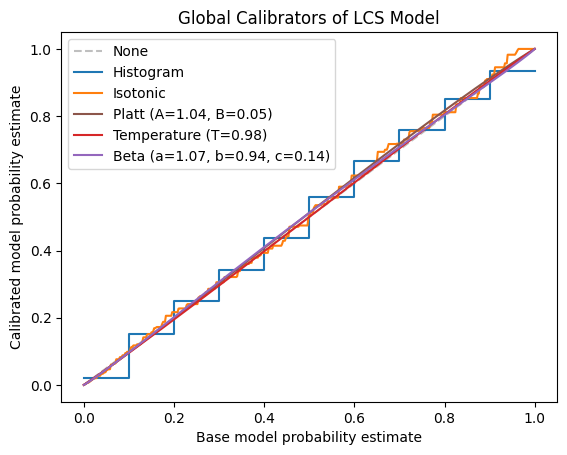

In [263]:
# M1
plot_global_calibrators(M1_concepts_cal, "LCS", path = "Results/CUB/calibration_functions/seqCBM-LCS.png")

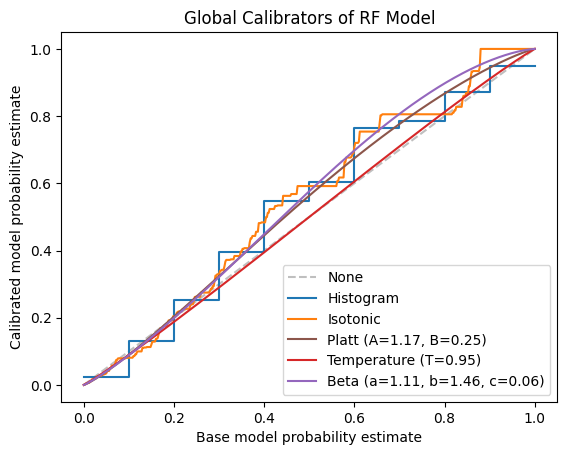

In [146]:
plot_global_calibrators(M3_concepts_cal, "RF", path = "Results/CUB/calibration_functions/seqCBM-RF.png")

#### Summarize individual calibrators

In [342]:
def get_calibrator_params(concept_models):
    temp_Ts  = np.array([params['T'] for params in concept_models['Temperature individual'].params.values()])
    platt_As = np.array([params['A'] for params in concept_models['Platt individual'].params.values()])
    platt_Bs = np.array([params['B'] for params in concept_models['Platt individual'].params.values()])
    beta_as  = np.array([params['a'] for params in concept_models['Beta individual'].params.values()])
    beta_bs  = np.array([params['b'] for params in concept_models['Beta individual'].params.values()])
    beta_cs  = np.array([params['c'] for params in concept_models['Beta individual'].params.values()])

    params = {'Temperature (T)' : temp_Ts, 
              'Platt (A)'       : platt_As, 
              'Platt (B)'       : platt_Bs, 
              'Beta (a)'        : beta_as, 
              'Beta (b)'        : beta_bs, 
              'Beta (c)'        : beta_cs
             }
    return params

def print_calibrator_params(params):
    for name, arr in params.items():
        est = np.mean(arr)
        n = len(arr)
        ste = ((arr - est)**2).sum()
        ste = ste**0.5 / (n * (n - 1))**0.5
        print("{} {} : {:.3f} \u00B1 {:.3f}".format(name, " "*(16 - len(name)), est, ste))

In [343]:
M1_params = get_calibrator_params(M1_concepts_cal)
print_calibrator_params(M1_params)

Temperature (T)   : 0.974 ± 0.003
Platt (A)         : 1.289 ± 0.036
Platt (B)         : 1.225 ± 0.204
Beta (a)          : 1.189 ± 0.041
Beta (b)          : 4.640 ± 1.137
Beta (c)          : 0.744 ± 0.220


In [344]:
M3_params = get_calibrator_params(M3_concepts_cal)
print_calibrator_params(M3_params)

Temperature (T)   : 0.940 ± 0.006
Platt (A)         : 4.114 ± 0.131
Platt (B)         : 9.202 ± 0.572
Beta (a)          : 3.416 ± 0.146
Beta (b)          : 15.761 ± 2.285
Beta (c)          : 6.747 ± 0.635


#### Crazy plots

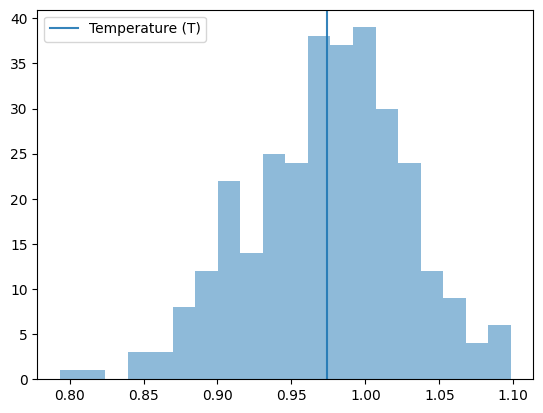

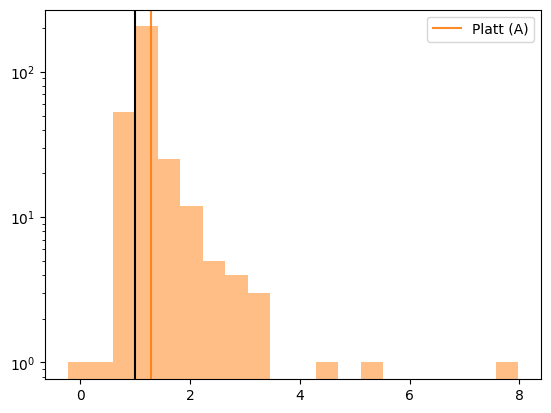

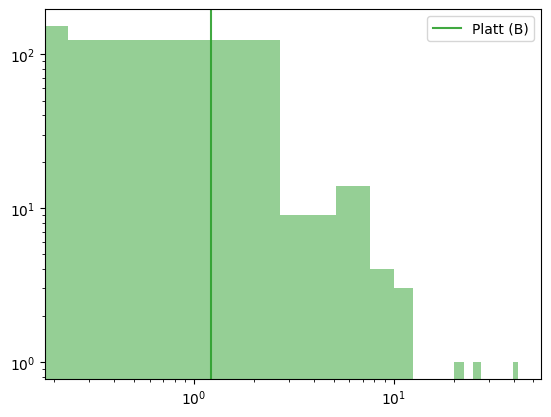

In [346]:
temp_Ts = M1_params['Temperature (T)']
plt.hist(temp_Ts, bins = 20, color = colors[0], alpha = 0.5)
plt.axvline(np.mean(temp_Ts), color = colors[0], label = 'Temperature (T)', alpha = 0.9)
plt.legend()
plt.show()

platt_As = M1_params['Platt (A)']
plt.hist(platt_As, bins = 20, color = colors[1], alpha = 0.5)
plt.axvline(1, color = 'black')
plt.axvline(np.mean(platt_As), color = colors[1], label = 'Platt (A)', alpha = 0.9)
#plt.xlim(-2, 2)
plt.yscale('log')
plt.legend()
plt.show()

platt_Bs = M1_params['Platt (B)']
plt.hist(platt_Bs, bins = 20, color = colors[2], alpha = 0.5)
plt.axvline(0, color = 'black')
plt.axvline(np.mean(platt_Bs), color = colors[2], label = 'Platt (B)', alpha = 0.9)
#plt.xlim(-2, 2)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

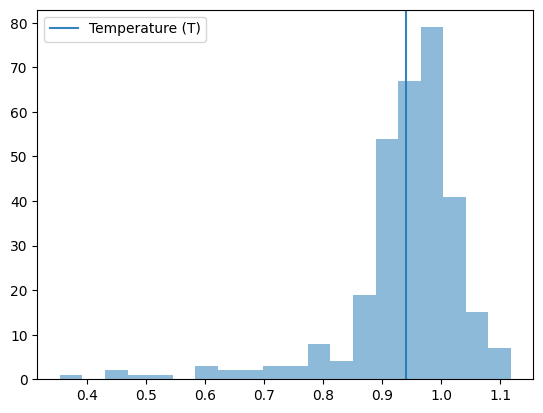

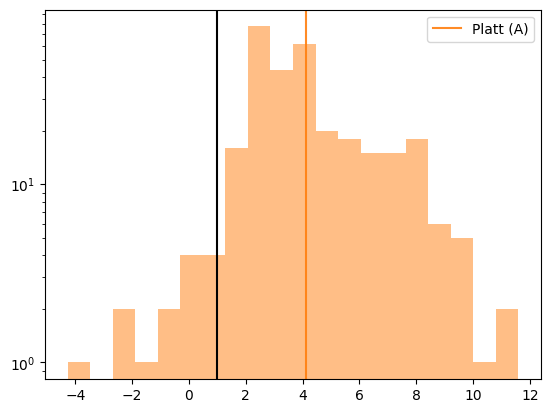

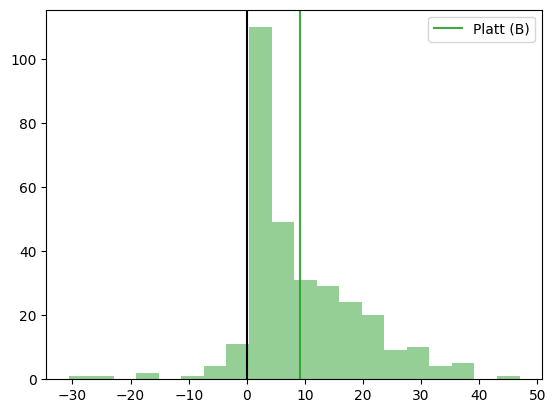

In [348]:
temp_Ts = M3_params['Temperature (T)']
plt.hist(temp_Ts, bins = 20, color = colors[0], alpha = 0.5)
plt.axvline(np.mean(temp_Ts), color = colors[0], label = 'Temperature (T)', alpha = 0.9)
plt.legend()
plt.show()

platt_As = M3_params['Platt (A)']
plt.hist(platt_As, bins = 20, color = colors[1], alpha = 0.5)
plt.axvline(1, color = 'black')
plt.axvline(np.mean(platt_As), color = colors[1], label = 'Platt (A)', alpha = 0.9)
#plt.xlim(-2, 2)
plt.yscale('log')
plt.legend()
plt.show()

platt_Bs = M3_params['Platt (B)']
plt.hist(platt_Bs, bins = 20, color = colors[2], alpha = 0.5)
plt.axvline(0, color = 'black')
plt.axvline(np.mean(platt_Bs), color = colors[2], label = 'Platt (B)', alpha = 0.9)
#plt.xlim(-2, 2)
#plt.xscale('log')
#plt.yscale('log')
plt.legend()
plt.show()